# **Project: Basics of Mobile Robotics**

Group 37:
- Bricq Marin
- Jousson Kento
- Tafili Mentor
- Wicht Alan

## 1) Introduction

In the constantly evolving field of robotics, the design and development of autonomous navigation systems represents a stimulating challenge. Our project aims to create a mobile robot capable of moving autonomously on a simple white map, skilfully avoiding fixed black obstacles detected by a camera. The aim is to enable the robot to navigate efficiently towards a defined destination despite the presence of unexpected obstacles introduced along the way.  

The project is divided into 4 distinct parts: computer vision, global navigation, local avoidance and the Kalman filter. The computer vision part was implemented using the OpenCV library and the ArUco module, enabling robust and efficient implementation of marker detection and other computer vision tasks. For global navigation, we chose the Dijkstra algorithm over the A* algorithm. This choice is due to the simplicity of our map and the small number of nodes detected and used to calculate the optimal path. Then, for the local avoidance part, the potential field principle seen in class was applied. For the filtering and estimation of the robot's position, we implemented an extended Kalman filter.

### The environment

The robot is going to move around on a A0 paper (841 x 1189 mm). On this map, two kinds of obstacles can be found:
- **Black obstacles**: these are static obstacles, they are detected by the camera during the initialisation phase and are not supposed to move during the whole execution of the program. From them, the algorithm will build a global map for the robot to move in.
- **White obstacles**: these are dynamic obstacles, they are **NOT** detected by the camera during the initialisation phase and will change positions during the run. The Thymio is supposed to avoid them while keeping its global path.

The Thymio and the goal are detected thanks to ArUco markers (see [section 3](#3-computer-vision-and-extraction-of-the-map)). The goal is going to be fixed during the whole execution of the program.

An example of the environment is shown below:

<p align="center">
  <img src="images/frame_ex.jpg" width="400">
  <br>
  Figure 1: Example of the environment as seen by the camera
</p>

## 2) Import the libraries

To run our code, we need to import the following libraries:

In [1]:
import cv2
import numpy as np
import copy
import time

import vision
import kalman
import dijkstra
import local_nav

import matplotlib.pyplot as plt
%matplotlib inline

from threading import Timer


## 3) Computer vision and extraction of the map

After a frame is captured, the image is processed to extract the map. The processing is entirely done using OpenCV [(1)](#sources) and the functions are in the file `vision.py`.
This map will be used to localize the robot and to plan the path. The map is extracted by the function `vision.extract_map()` using the following steps:

1. The ArUCO markers for the goal and the robot are detected and their position is extracted. They are hidden from the map using white rectangles.
2. The image is converted to grayscale and a threshold is applied to extract the obstacles.
3. The obstacles are first eroded and then dilated to remove gaps or noise. They are then dilated again to make them bigger so that the robot can avoid them. This steps is done using morphological filters in particular `cv2.erode()` and `cv2.dilate()`. The kernel used is a circle which size is equal to the robot.
4. Minimum area rectangles are fitted to the obstacles to find vertices of the map. The function used is `cv2.minAreaRect()`. The vertices are then removed if they are out of the map.
5. The vertices are linked together to form the map only if no obstacle is present between them. This is done by sampling points between the vertices and checking if they are obstacles, the number of points sampled is proportional to the distance between the vertices.
6. The objects returned is a list of the vertices and an adjacency matrix. The first vertex is the robot and the last vertex is the goal.

ArUco markers are taken from the ArUco library [(2)](#sources). We are using the 4x4 dictionary with 50 markers. They are printed on 39x39 mm. The robot marker's id is 3 and the goal is 4. OpenCV's ArUco library is used to detect the markers and their position is extracted. This allows to find both the position and the orientation as the four corners are detected in a specific order.

The adjacency matrix is a matrix of size nxn where n is the number of vertices. The value at position (i,j) is equal to the distance between the vertices i and j. If there is an obstacle between the two vertices, the value is set to -1. The order of the vertices is the same as the order in the list of vertices.

As a demonstration, the code below shows how the map is extracted from one frame, here the display of three main steps (steps 3, 4 and 5) is shown.

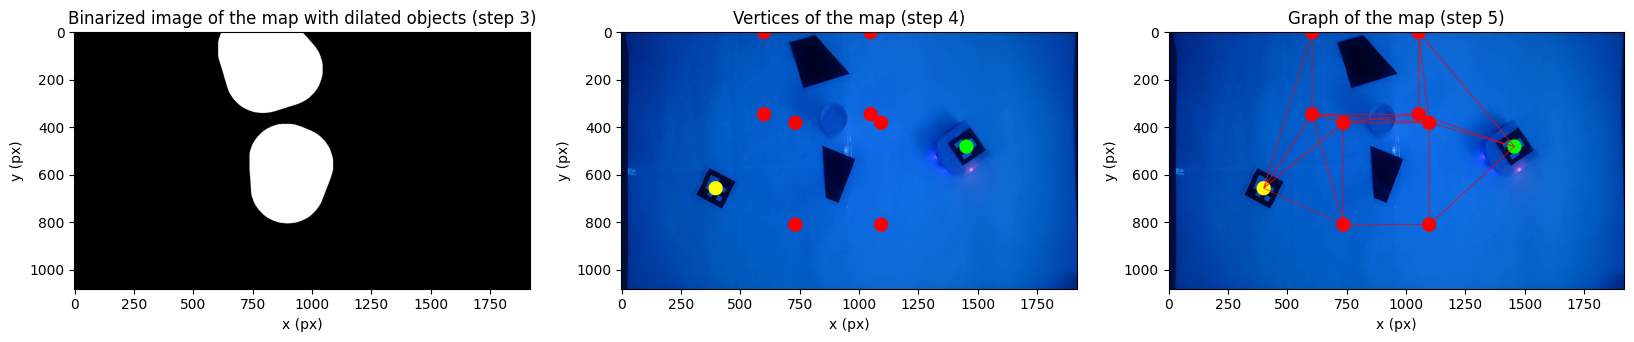

In [3]:
frame = cv2.imread('images/frame_ex.jpg')

vertex_list, adj_matrix, binarized_map, m_per_pixel = vision.extract_map(frame, True)

vertex_list_m = vertex_list * m_per_pixel

<p align="center">
Figure 2: Different images along the pipeline to extract the map
</p>

One can notice that the white object (a dynamic obstacle) is indeed not detected by the camera.

For any frame, the robot's ArUco marker is detected and its position is extracted. The function `vision.detect_robot()` returns the robot's position and orientation in the map with respect to the map's origin (top left of the image). It is critical that the camera is not moved for the whole duration of the path planning and execution.

If the robot is not detected, the value [-1, -1] is returned. Furthermore, the algorithm also checks if the goal is visible to detect if the whole camera is hidden or if the robot is kidnapped.

The goal is detected!
The robot is detected!


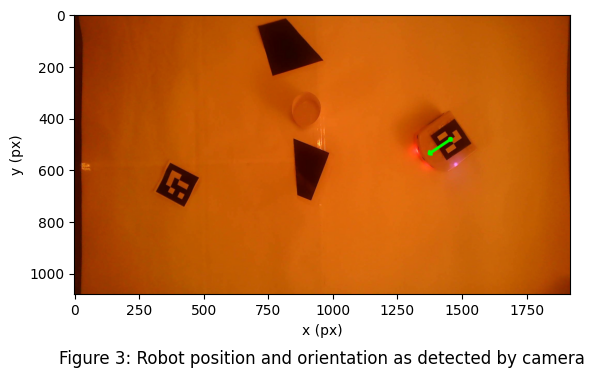

In [4]:
# Using the same frame as example
robot_pos, orientation, goal_det = vision.detect_robot(frame)

if goal_det:
    print('The goal is detected!')
else:
    print('The goal is not detected!')
    
if np.all(robot_pos != -1):
    print('The robot is detected!')
    
    # Display the robot position and orientation
    img = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    
    img = cv2.circle(img, (int(robot_pos[0]), int(robot_pos[1])), 10, (0, 255, 0), -1)
    img = cv2.arrowedLine(img, (int(robot_pos[0]), int(robot_pos[1])), (int(robot_pos[0] + 100 * np.cos(orientation)), int(robot_pos[1] + 100 * np.sin(orientation))), (0, 255, 0), 10)
    
    plt.xlabel("x (px)")
    plt.ylabel("y (px)")
    plt.title("Figure 3: Robot position and orientation as detected by camera", y=-0.28)
    
    plt.imshow(img)
else:
    print('The robot is not detected!')

The obtained adjacency matrix is given in the following cell.

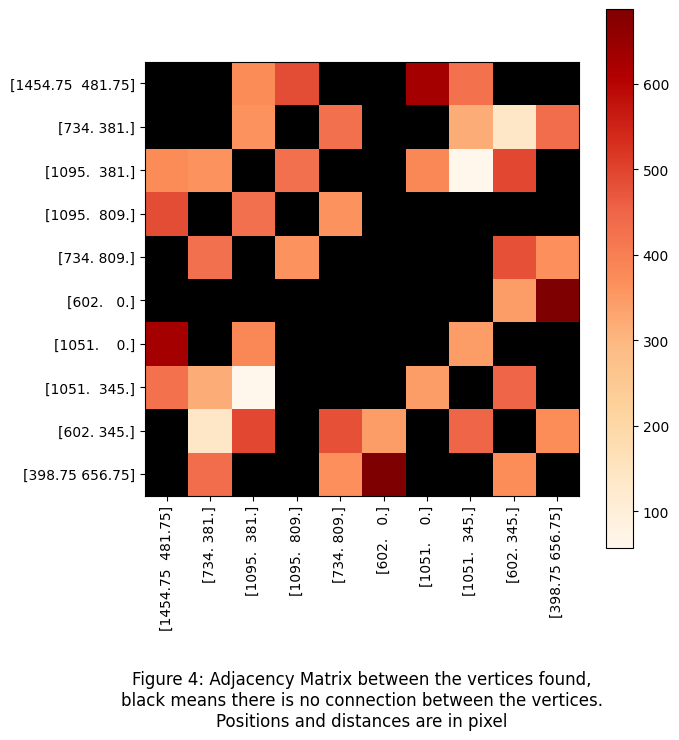

In [5]:
# Display the adjacency matrix
adj_display = copy.copy(adj_matrix)
adj_display[adj_display == -1] = np.nan

cmap = plt.cm.OrRd
cmap.set_bad(color='black')

fig, ax = plt.subplots(1, 1, figsize=(7, 7))

im_adj = ax.imshow(adj_display, cmap=cmap)
ax.set_title("Figure 4: Adjacency Matrix between the vertices found,\nblack means there is no connection between the vertices.\nPositions and distances are in pixel", y=-0.55)
ax.set_xticks(np.arange(vertex_list.shape[0]), vertex_list, rotation='vertical')
ax.set_yticks(np.arange(vertex_list.shape[0]), vertex_list)
fig.colorbar(im_adj)

plt.show()

## 4) Path planning



Now, we will be talking more specifically about the Global Navigation of the project. During our first group discussion, we discussed about
what type of project we wanted to do. Regarding the type of map and the needs we had, we decided to implement a Dijkstra algorithm.
The concept of the algorithm is quite simple. The map is consitued of many different nodes, which are determined with the position of the
different obstacle angles, the position of the robot and the position of the goal that should be attained. 

The first function that we see below is useful to compare the different paths that are calculated with the help of the Dijkstra algorithm. 
It's working principle is therefore really simple. We have two inputs : `came_from` which is a "map" that contains the node that preceds the one we are currently on with the shortest path to it, and `current` which is simply the value of the node we are currently at.

The second function is the shortest path algorithm `Dijkstra`. The theory behind the Dijkstra algorithm is quite simple. We have a map with different nodes and paths that can be taken to go from a starting point to an ending point, and the algorithm will help us to find the shortest path to go from the start to the goal. We only have one input `node_matrix` which is a matrix of all the nodes present on the map which will be used to find the best possible path. To do so, we will create many different lists, for example `open_set` which will contain the set of visited nodes whose neighbors need to be explored, or `closed_set` which will help us remember which nodes we have already visited.

Below, on the Figure 5, we have a sketch of a map. On it, we can see the nodes and paths, and more specifically the starting node S and the goal node G

<p align="center">
  <img src="images/D-1.png" width="400">
</p>
<figcaption align="center">Figure 5: Imaginary map that could be given by the extraction from the vision</figcaption>

And now, on Figure 6, we see the result that we will get if we apply the Dijkstra algorithm on it. The shortest path is in red and the best nodes in green

<p align="center">
  <img src="images/D-2.png" width="400">
</p>
<figcaption align="center">Figure 6: Optimal path returned by Dijkstra</figcaption>

The code below shows us what is returned when the Dijkstra is used. We have a list of the optimal path or nodes that should be followed, and the coordinates that correspond to each node in meter. Those informations will later be used to tell the robot where to move.

In [6]:
path = dijkstra.global_path(adj_matrix)

print("The global path is going to be the following nodes' index: {}".format(path))

str_nodes = " --> ".join(["[{:.3f}, {:.3f}]".format(i[0], i[1]) for i in vertex_list_m[path]])

print("Which corresponds to the following vertices (positions in m):\n", str_nodes)

The global path is going to be the following nodes' index: [0, 2, 1, 9]
Which corresponds to the following vertices (positions in m):
 [0.561, 0.186] --> [0.422, 0.147] --> [0.283, 0.147] --> [0.154, 0.253]


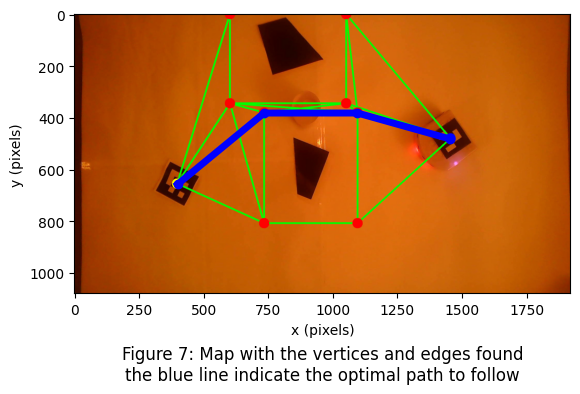

In [7]:
img = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

for i in range(len(vertex_list)):
    for j in range(len(vertex_list)):
        if adj_matrix[i, j] != -1:
            img = cv2.line(img, (int(vertex_list[i, 0]), int(vertex_list[i, 1])), (int(vertex_list[j, 0]), int(vertex_list[j, 1])), (0, 255, 0), 5)
    
for i in range(len(vertex_list)):
    color_dot = (255, 0, 0)
    
    if i == 0:
        color_dot = (0, 0, 255)
    elif i == len(vertex_list) - 1:
        color_dot = (255, 255, 0)
    
    img = cv2.circle(img, (int(vertex_list[i, 0]), int(vertex_list[i, 1])), 20, color_dot, -1)
    
plt.xlabel("x (pixels)")
plt.ylabel("y (pixels)")
plt.imshow(img)
plt.title("Figure 7: Map with the vertices and edges found\nthe blue line indicate the optimal path to follow", y=-0.34)
plt.plot(vertex_list[path][:, 0], vertex_list[path][:, 1], 'b-o', linewidth=5)
plt.show()

## 5) Local Navigation

In the `local_nav` module, the state of the robot alternates between two distinct states: state 0 for global navigation and state 1 for local avoidance. If one of the proximity sensors detects an object, the program switches to state 1. If none of the sensors detects an object, the program returns to state 0. Local avoidance works according to the potential field principle seen in the lesson. To the base speed of the robot is added each value returned by each of the proximity sensors multiplied by a gain : `obstSpeedGain`. In addition to these values, another component, generated by the difference between the orientation of the robot and the direction of the goal, is added to the robot's speed. In this way, the robot is drawn towards the goal regardless of its current state, enabling it to optimise its trajectory.

<p align="center">
  <img src="images/local.png" width="500">
  <div align="center">Figure 8: Representation of local_nav</div>
</p>

The figure above shows our `local_nav` module. As you can see, in each of the states, the attraction to the goal is present. Obstacle repulsion is activated when the sensors detect an object. It overrides this attraction, while taking it into account to optimise the robot's path. In the case shown above right, the right sensors will perceive an obstacle, which will lead to a negative speed for the left wheel and a positive speed for the left wheel.

Additionally, the speed of the robot is calculated from a PD controller based on `deltaAngle`, which is the orientation error between the goal and that of the robot. We needed reactivty for the robot to be able to perform sharp turns, but we never encountered an issue of steady-state error, so a PID is not necessary.

It is then adapted according to a sigmoid function. The latter allows the speed of the robot to be adapted according to its distance from its next target. The robot is at its maximum speed 300 when it is far from its next target. The closer he gets to his target, the more he slows down, in order to increase his precision in his movements and turns. Thus, approximately 10cm from its target, it advances at a speed of 200. Below is a representation of the sigmoid function in question.

<p align="center">
  <img src="images/speed_dist.png" width="500">
  <div align="center">Figure 9: Function to get the base speed of the robot.<br>The x-axis is the distance in meter, the y-axis is the Thymio speed given to the robot.</div>
</p>

## 6) Kalman filter
<h3>Model</h3>

We used an Extended Kalman Filter (EKF) with continuous time model and discrete time measurement [(3)](#sources). The model [(4)](#sources):
$${\bold{x}}
=
\begin{bmatrix}
x \\
y \\
\theta \\
v_r \\
v_l \\
\end{bmatrix} \Rightarrow \dot {\bold{x}}
= 
\bold{f(x,u)} + \bold{w}
=
\begin{bmatrix}
\dot x \\
\dot y \\
\dot{\theta}\\
\dot{v_r} \\
\dot{v_l} \\
\end{bmatrix} + \bold{w}
=
\begin{bmatrix}
\frac{cos(\theta)}{2} (v_r + v_l) \\
\frac{sin(\theta)}{2} (v_r + v_l) \\
\frac{v_l - v_r}{2l} \\
0 \\
0 \\
\end{bmatrix} + \bold{w}$$

$x, y, \theta$ are the absolute position of the robot, $v_r $ and $ v_l$ are the speed of the right and the left wheel at the contact point, $l$ is half the length of the wheelbase and $\bold{w} \sim \mathcal{N} (\bold{0,Q})$ is the process noise. The acceleration of the wheel are assumed to be 0 and will therefore appear in the process noise !

<h3>Observation</h3>

The observation are given by:
$$ \bold{y^j} = \bold{h^j} + \bold{v^j} \ \ \ \ \ \ \ \bold{h}^{Camera}
= 
\begin{bmatrix}
x \\
y \\
\theta
\end{bmatrix} \ \ \ \ \ \ \  \bold{h}^{Wheels}
= 
\begin{bmatrix}
v_r \\
v_l \\
\end{bmatrix} = \begin{bmatrix}
\Omega_r \lambda\\
\Omega_r \lambda\\
\end{bmatrix} $$

with $\Omega_r, \ \Omega_l$ the angular velocity of the right and left wheel, $\lambda$ being the thymio speed to m/s ratio and $\bold{v^j} \sim \mathcal{N} (\bold{0,R^j})$ is the measurement noise. $j \isin \{Wheels, Camera \}$

We implemented a function that wraps the angle in $[-\pi, \pi]$ to let the robot do multiple turn on itself.

<h3>Notation</h3>

The `x_kk1` variable denotes the prediction $x_{k|k-1}$ at time k and x_kk denotes the updated estimation $x_{k|k}$ at time k this convention holds for $P_{kk}$.



## 7) Presentation of the FSM

Finally, here is the overview of the Final State Machine of the code. We can see all the different modules that we talked about previously and the links between all of them.

<p align="center">

  <img src="images/diagram_FSM.png" width="1000">
</p>

<figcaption align="center">Figure 10: FSM to control the Thymio</figcaption>

## Overall project

The first step we do before running the main loop is to check that the camera is correctly place above the working environement. This is done by capturing one frame and dispplaying it.

In [2]:
from tdmclient import ClientAsync
client = ClientAsync()
node = await client.wait_for_node()
await node.lock()

Node cdf2e9ac-08a7-428d-b940-576cb977b3b0

In [3]:
# Constants for the different parts
CAM_ID = 0

TIME_BETWEEN_FRAMES = 0.125 # In seconds
TIME_PLOT_UPDATE = 1 # In seconds

NUM_FRAMES_KIDNAP = 2

EPSILON_DIST = 2e-2 # In meter

thymio_speed_to_ms = 0.2 / 1000
std_speed = 12.306044894776846 * thymio_speed_to_ms # Convert the std to the right unit
q_wheel = std_speed/2 # variance on speed state

async def FSM(xkks, Pkks, no_robot, mes_wheels, times_data, mes_camera, times_camera):
    """Global function to run our algorithm. All the parameters are used to be able to plot afterwards the results.

    Args:
        xkks: States of the Kalman filter
        Pkks: Covariance matrices of the Kalman filter
        no_robot: Vector with 0 when the robot is detected and 1 when it is not
        mes_wheels: Measurements of the wheels
        times_data: Times at which the wheels is collected
        mes_camera: Measurements of the camera
        times_camera: Times at which the camera is read
    """

    # Variables necessary for the FSM
    state = 0 # 0 = global navigation and 1 = local avoidance
    current_goal_idx = 0

    num_frames_robot_unseen = 0
    
    # Open the camera
    cap = cv2.VideoCapture(CAM_ID)
    
    # Run first the algo to extract the map
    ret, frame = cap.read()
    
    if ret == False:
        print('Can\'t read the CAM(%d)' % (CAM_ID))
        assert(False)
    
    # Get the map
    positions_vertex, path, current_goal_idx, current_goal, robot_pos, orientation, m_per_pixel = dijkstra.generate_map(frame)
    
    #Init the Kalman
    P_kk = np.diag((5e-3,5e-3,5e-2,q_wheel,q_wheel)) # Initial covariance matrix equals to Q
    x_kk = np.array([robot_pos[0], robot_pos[1], orientation, 0, 0])
    
    # Create VideoWriter object to save the video
    filename = 'output_' + time.strftime("%Y%m%d-%H%M%S") + '.avi'
    output_video = cv2.VideoWriter(filename, cv2.VideoWriter_fourcc('M','J','P','G'), 5, (frame.shape[1], frame.shape[0]))
    
    # Create window for the live plot
    name_window = 'frame'
    cv2.namedWindow(name_window, cv2.WINDOW_NORMAL)
    cv2.startWindowThread()
    
    frame_drawn = vision.update_frame(frame, x_kk, P_kk, positions_vertex, path, current_goal_idx, m_per_pixel)
    
    cv2.imshow(name_window, frame_drawn)
    output_video.write(frame_drawn)
    cv2.waitKey(1)
    
    # Initialisation of the variables
    last_time_frame = time.time()
    last_time = time.time()
        
    while True:
        # Predict step for the Kalman filter
        dt = time.time() - last_time
        last_time = time.time()
        [x_kk1, P_kk1] = kalman.Predict(x_kk, P_kk, dt)
                
        # Wheel update of the Kalman filter
        measurement = np.array([node['motor.right.speed'], node['motor.left.speed']])
        [x_kk, P_kk] = kalman.WheelUpdate(measurement * thymio_speed_to_ms, x_kk1, P_kk1)
        mes_wheels.append(measurement * thymio_speed_to_ms)
        times_data.append(last_time)
        
        # Camera update of the Kalman filter only if the time between frames is reached
        if time.time() - last_time_frame >= TIME_BETWEEN_FRAMES:
            # Read the frame
            ret, frame = cap.read()
            if ret == False:
                print('Can\'t read the CAM(%d)' % (CAM_ID))
                continue
            
            robot_pos, orientation, goal_detect = vision.detect_robot(frame)

            # Check if the robot is detected
            if np.all(robot_pos != -1):
                robot_pos = robot_pos * m_per_pixel
                [x_kk, P_kk] = kalman.CameraUpdate(np.array([robot_pos[0], robot_pos[1], orientation]), x_kk, P_kk)
                mes_camera.append(np.array([robot_pos[0], robot_pos[1], orientation]))
                times_camera.append(last_time)
                no_robot.append(0)
                
                num_frames_robot_unseen = 0
            else:
                # No robot detected
                no_robot.append(1)

                if goal_detect:
                    # When the camera is not seeing the robot but the goal
                    # => it is not hidden
                    num_frames_robot_unseen += 1
                    
                    if num_frames_robot_unseen >= NUM_FRAMES_KIDNAP:
                        # The robot is not seen for more than NUM_FRAMES_KIDNAP frames
                        # => the robot is kidnapped
                        print("Kidnapped!")
                        
                        await node.set_variables(local_nav.motors(0,0))
                        
                        # Wait until the robot is seen again
                        while (np.all(robot_pos == -1) or not goal_detect):
                            ret, frame = cap.read()
                            
                            if ret != False:
                                robot_pos, orientation, goal_detect = vision.detect_robot(frame)
                            
                            await client.sleep(0.1)
                    
                        print("Rescued!")
                        
                        # Get the map
                        positions_vertex, path, current_goal_idx, current_goal, robot_pos, orientation, m_per_pixel = dijkstra.generate_map(frame)
                        
                        num_frames_robot_unseen = 0
                                    
            last_time_frame = time.time()
        else:
            no_robot.append(0)
            
                
        xkks.append(x_kk)
        Pkks.append(P_kk)
            
        robot_to_goal = current_goal - x_kk[:2]
        
        # calculates the orientation of the goal in relation to the robot's position
        orient_goal = np.arctan2(robot_to_goal[1],robot_to_goal[0])
        #calculates the angle between the actual orientation of the robot and the direction of the goal
        deltaAngle = orient_goal - x_kk[2]
        deltaAngle = kalman.Wrap2Pi(deltaAngle)
                
        dist_to_goal = np.linalg.norm(robot_to_goal)
        
        if dist_to_goal < EPSILON_DIST:
            #print("Goal {:d} reached".format(current_goal_idx))
            current_goal_idx += 1
            
            if current_goal_idx >= len(path):
                print("Path completed")
                break
            
            current_goal = positions_vertex[path[current_goal_idx]]
        
        # Update the live plot
        frame_drawn = vision.update_frame(frame, x_kk, P_kk, positions_vertex, path, current_goal_idx, m_per_pixel)
        cv2.imshow(name_window, frame_drawn)
        output_video.write(frame_drawn)
        cv2.waitKey(1)
        
        # Update the motors only if the time between motor updates is reached
        [motor_left_target,motor_right_target] = local_nav.controller_pd(node['prox.horizontal'], dist_to_goal, deltaAngle, state)
        await node.set_variables(local_nav.motors(motor_left_target,motor_right_target))            
        
        await client.sleep(0.01)
    
    # Stop the robot
    await node.set_variables(local_nav.motors(0,0))
    
    # Close the camera
    cap.release()
    
    # Close the video
    output_video.release()
    
    # Close the live plot
    cv2.waitKey(0)
    cv2.destroyAllWindows()
    cv2.waitKey(1)
    
    print("End of the algorithm")
    

In [6]:
await node.wait_for_variables()

# Lists to store the data for debugging
xkks = []
Pkks = []
mes_wheels = []
mes_camera = []
no_robot = []
times_camera = []
times_data = []

# Run the FSM
await FSM(xkks, Pkks, no_robot, mes_wheels, times_data, mes_camera, times_camera)

Kidnapped!
Rescued!
Kidnapped!
Rescued!
Kidnapped!
Rescued!
Path completed
End of the algorithm


In [4]:
await node.stop()

## Conclusion

At the end, in the controlled environment, the Thymio robot is able to navigate and reach its goal. It manages to avoid unexpected obstacles and even to keep its goal while the camera is hidden. Finally, it is possible to kidnap the robot and it will still be able to reach its goal.

The environment can be generalized to any white map with black obstacles. The only constraint is that the camera should be placed above the map and should not be moved during the whole execution of the program. Furthermore, the camera needs to have a sufficient good resolution to detect the ArUco markers.

The team managed to work well together and to split the work efficiently. The project was a good opportunity to learn more about the different aspects of mobile robotics and to apply the theory seen in class.

## Sources

1) https://opencv.org/

2) https://docs.opencv.org/3.4/d5/dae/tutorial_aruco_detection.html

3) https://en.m.wikipedia.org/wiki/Extended_Kalman_filter#Discrete-time_measurements 

4) Autonomous Mobile Robots, ETHZ, Spring 2021 by professors Roland Siegwart, Margarita Chli and Nicholas Lawrance

5) Course Basics of Mobile Robotics, EPFL, Fall 2023 by professor Francesco Mondada